# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

**2023 update:** Changed to packages `gymnasium` and `renderlab`, and to `CartPole-v1`.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
!pip install gymnasium
!pip install renderlab

 **If run on your local machine**, you may need to install `gymnasium[classic-control]` by running the following line:

In [2]:
!pip install "gymnasium[classic-control]"

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import renderlab as rl

First we create the environment:

In [4]:
env = gym.make('CartPole-v1') # Create environment

A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [5]:
s, _ = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.04613871 -0.0170048   0.01900671 -0.04261327]
sample action: 0


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [6]:
env = gym.make("CartPole-v1", render_mode = "rgb_array") # Create environment
env = rl.RenderFrame(env, "./output") # To display environment in the notebook
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [7]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network with an additional hidden layer
        self.hidden1 = nn.Linear(n_inputs, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)  # New hidden layer
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)  # Forward through the new hidden layer
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [8]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [9]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [10]:
# training settings

num_episodes = 1500  # Increased number of episodes
rollout_limit = 500  # Max rollout length
discount_factor = 0.99  # Adjusted discount factor
learning_rate = 0.005  # Increased learning rate
val_freq = 100  # Validation frequency

# Setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# Train policy network
try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # Generate rollout by evaluating the current policy
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        
        # Prepare batch
        states, actions, rewards = zip(*rollout)
        states = np.vstack(states)
        actions = np.vstack(actions)
        rewards = np.array(rewards, dtype=float)
        returns = compute_returns(rewards, discount_factor)
        
        # Policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()

        # Bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        
        # Print
        if (i+1) % val_freq == 0:
            # Validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  25.41, mean validation reward:  17.00, mean loss:  8.1468
 200. mean training reward:  25.15, mean validation reward:  22.10, mean loss:  8.0499
 300. mean training reward:  36.43, mean validation reward:  37.30, mean loss: 10.0862
 400. mean training reward:  18.61, mean validation reward:  17.70, mean loss:  5.2672
 500. mean training reward:  18.60, mean validation reward:  34.30, mean loss:  4.9888
 600. mean training reward:  88.69, mean validation reward:  41.90, mean loss: 16.8270
 700. mean training reward:  98.30, mean validation reward: 309.00, mean loss: 12.5585
 800. mean training reward:  72.91, mean validation reward:  78.10, mean loss: 11.2320
 900. mean training reward:  71.04, mean validation reward: 108.30, mean loss: 10.0425
1000. mean training reward: 430.28, mean validation reward: 500.00, mean loss: 30.2342
1100. mean training reward: 491.70, mean validation reward: 500.00, mean loss: 35.3146
1200. mean training reward: 

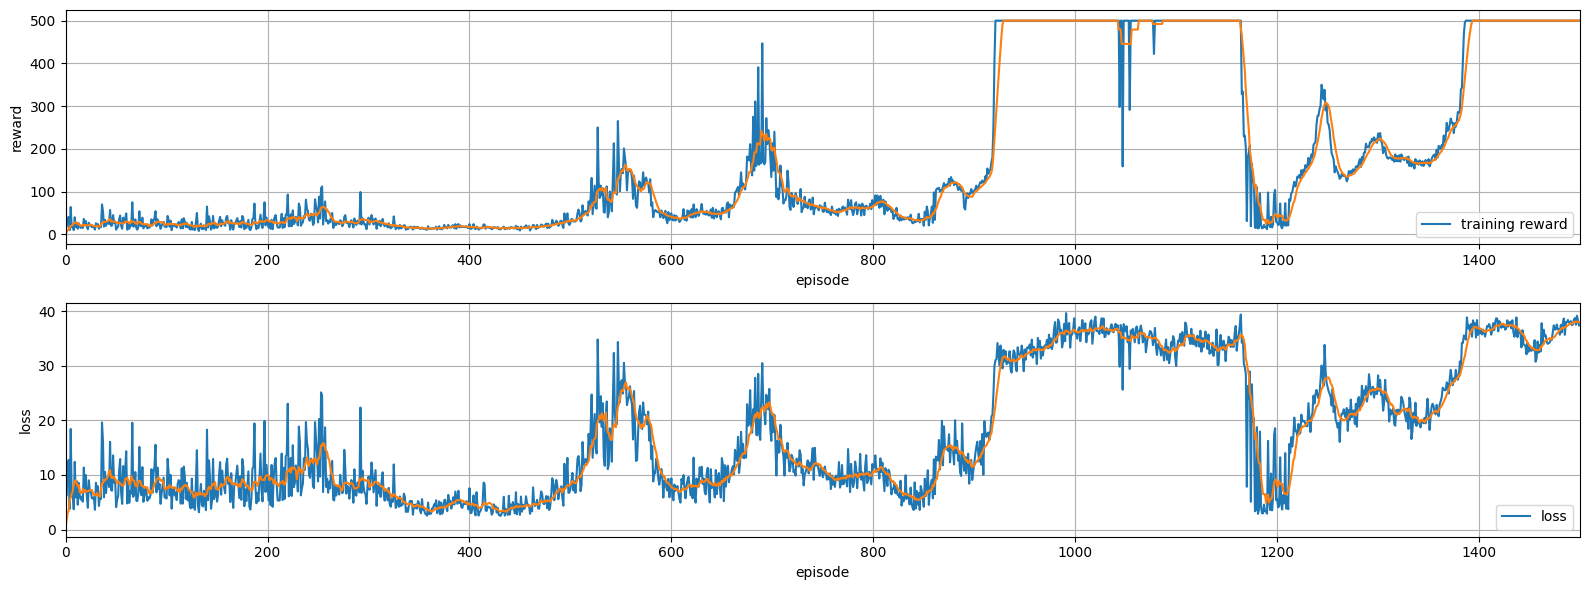

In [11]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [12]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

I changed the number of episodes from 800 to 1500. This allows the agent more opportunities to learn and improve its performance. More episodes help the agent explore different strategies to balance the pole, leading to better training outcomes.
Adjusted Discount Factor:

I set the discount factor (gamma) to 0.99 instead of 1.0. This helps the agent prioritize long-term rewards over immediate ones. It encourages the agent to consider future actions, which is crucial for tasks that require planning.
Increased Learning Rate:

I increased the learning rate from 0.001 to 0.005. A higher learning rate can speed up the training process, allowing the agent to adapt more quickly to the environment. This can lead to faster improvements in performance, although it requires careful tuning to avoid instability.
Added Hidden Layer:

I added an extra hidden layer to the policy network. This increases the capacity of the model, allowing it to learn more complex relationships in the data. A more complex model can potentially capture better strategies for balancing the pole.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

1) **Total reward = 5** which is the whole sum of rewards from the list prepared above

2) **Future_total_reward = [5, 4, 3, 2, 2, 2, 1, 0, 0, 0]**

3) Discounted future reward
1. **Timestep 9**: 
   $$
   \text{Discounted Future Reward}(9) = 0
   $$

2. **Timestep 8**: 
   $$
   \text{Discounted Future Reward}(8) = 0 + 0.9 \times 0 = 0
   $$

3. **Timestep 7**: 
   $$
   \text{Discounted Future Reward}(7) = 0 + 0.9 \times 0 = 0
   $$

4. **Timestep 6**: 
   $$
   \text{Discounted Future Reward}(6) = 1 + 0.9 \times 0 = 1
   $$

5. **Timestep 5**: 
   $$
   \text{Discounted Future Reward}(5) = 1 + 0.9 \times 1 = 1 + 0.9 = 1.9
   $$

6. **Timestep 4**: 
   $$
   \text{Discounted Future Reward}(4) = 0 + 0.9 \times 1.9 = 0 + 1.71 = 1.71
   $$

7. **Timestep 3**: 
   $$
   \text{Discounted Future Reward}(3) = 1 + 0.9 \times 1.71 = 1 + 1.539 = 2.539
   $$

8. **Timestep 2**: 
   $$
   \text{Discounted Future Reward}(2) = 1 + 0.9 \times 2.539 = 1 + 2.2851 = 3.2851
   $$

9. **Timestep 1**: 
   $$
   \text{Discounted Future Reward}(1) = 1 + 0.9 \times 3.2851 = 1 + 2.95659 = 3.95659
   $$

10. **Timestep 0**: 
    $$
    \text{Discounted Future Reward}(0) = 0 + 0.9 \times 3.95659 = 0 + 3.560931 = 3.560931
    $$

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

*I would say that validation reward often starts lower than the training reward probably, because during the training an agent explores the environment, what can lead to suboptimal actions and lower overall rewards. In contrast, during validation, the agent exploits its learned policy, allowing it to perform better by selecting the best actions. As training progresses, the policy becomes more refined and effective, leading to higher validation rewards that eventually surpass the training rewards. This behavior suggests that the agent is learning to generalize and adapt to different situations more effectively, rather than just optimizing for the specific training episodes.*

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

*By balancing exploration (trying new actions) and exploitation (choosing the best-known actions), the policy gradient method helps the agent improve its performance over time while still learning about its environment. This way, the agent doesn’t get stuck only using what it already knows but continues to learn and adapt.*

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

### Additional exercise from the book

There is a way of determining the bitwise representation of a digit by adding an extra layer to the three-layer network above. The extra layer converts the output from the previous layer into a binary representation, as illustrated in the figure below. Find a set of weights and biases for the new output layer. Assume that the first 3
 layers of neurons are such that the correct output in the third layer (i.e., the old output layer) has activation at least 0.99
, and incorrect outputs have activation less than 0.01
.

# Binary Conversion Layer for One-Hot Encoded Digits

### Problem

Given:
- A third layer in our neural network that outputs a **one-hot encoded vector** of 10 neurons, representing digits 0 through 9.

Goal:
- Add a **fourth layer** with 4 neurons that outputs the **binary representation** of each digit (e.g., digit 5 should output `[0, 1, 0, 1]`).

### Solution Approach

1. **One-Hot to Binary Conversion**:
   - Each digit $d$ has a unique binary representation:
     - 0 is $0000$
     - 1 is $0001$
     - … and 9 is $1001$
   - For example, digit 5 (represented as `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`) should convert to binary `[0, 1, 0, 1]`.

2. **Defining Weights and Biases for the Fourth Layer**:
   - **Weights**: We use a $4 \times 10$ matrix where each row of weights corresponds to a binary bit (from least to most significant):
     - The first row represents the **least significant bit**.
     - The fourth row represents the **most significant bit**.

   **Weight Matrix**:
   $$
   W = \begin{bmatrix}
   0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 \\  % \text{2}^0 \text{ (LSB)}
   0 & 0 & 1 & 1 & 0 & 0 & 1 & 1 & 0 & 0 \\  % \text{2}^1 \text{ bit}
   0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 \\  % \text{2}^2 \text{ bit}
   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1     % \text{2}^3 \text{ (MSB)}
   \end{bmatrix}
   $$

   - **Biases**: Set all biases to $-0.5$. This threshold ensures each neuron outputs 1 only if its binary bit should be 1.

   **Bias Vector**:
   $$
   b = \begin{bmatrix} -0.5 \\ -0.5 \\ -0.5 \\ -0.5 \end{bmatrix}
   $$

### How It Works

With these weights and biases:
- For any one-hot encoded input, the fourth layer outputs the correct binary representation.
- Example:
  - Input $y^{(3)} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$ (digit 5) produces $y^{(4)} = [1, 0, 1, 0]$ (binary for 5).

This setup efficiently converts one-hot encoded digits to binary form.